In [ ]:
!pip install pyspark
from pyspark.sql import *

spark= SparkSession.builder\
.master("local")\
.appName("Colab")\
.config('spark.ui.port', '4050')\
.getOrCreate()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 199 kB 59.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=fc6e4782e8f3f5be8751470e67de053ce04252960183e16bd30fddde36c6c18e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
from  pyspark import pandas

In [ ]:
import pandas as pd
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022?select=Combined_Flights_2022.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alialnujaidi
Your Kaggle Key: ··········


100%|██████████| 3.73G/3.73G [00:23<00:00, 167MB/s]


In [ ]:
df = spark.read.option("header",True) \
     .csv("flight-delay-dataset-20182022/Combined_Flights_2022.csv")

In [ ]:
df = df.select("AirTime","Distance","DepTime")

In [ ]:
df.show(5)

+-------+--------+-------+
|AirTime|Distance|DepTime|
+-------+--------+-------+
|   40.0|   212.0| 1123.0|
|   55.0|   295.0|  728.0|
|   47.0|   251.0| 1514.0|
|   57.0|   376.0| 1430.0|
|   49.0|   251.0| 1135.0|
+-------+--------+-------+
only showing top 5 rows



In [ ]:
df = df.withColumn("AirTime",col("AirTime").cast("int")).dropna("any")
df = df.withColumn("Distance",col("Distance").cast("int")).dropna("any")
df = df.withColumn("DepTime",col("DepTime").cast("int")).dropna("any")

In [ ]:
df.describe().show()

+-------+------------------+-----------------+-----------------+
|summary|           AirTime|         Distance|          DepTime|
+-------+------------------+-----------------+-----------------+
|  count|           3944916|          3944916|          3944916|
|   mean|111.00754870319165|798.8928636249796|1334.120380763494|
| stddev| 69.96245895307061|593.1635201368039|505.7184102507513|
|    min|                 8|               31|                1|
|    max|               727|             5095|             2400|
+-------+------------------+-----------------+-----------------+



In [ ]:
df = df.withColumn("AirTime", df.AirTime/727)
df = df.withColumn("Distance", df.Distance/5095)
df = df.withColumn("DepTime", df.DepTime/2400)

In [ ]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|             AirTime|            Distance|             DepTime|
+-------+--------------------+--------------------+--------------------+
|  count|             3944916|             3944916|             3944916|
|   mean| 0.15269263920660694| 0.15679938442095578|  0.5558834919849465|
| stddev| 0.09623446898634216|  0.1164207105273417| 0.21071600427114648|
|    min|0.011004126547455296|0.006084396467124632|4.166666666666667E-4|
|    max|                 1.0|                 1.0|                 1.0|
+-------+--------------------+--------------------+--------------------+



In [ ]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
input_cols = ['AirTime','Distance','DepTime']
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df = vec_assembler.transform(df)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(df)

In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.show()

+--------------------+--------------------+-------------------+--------------------+----------+
|             AirTime|            Distance|            DepTime|            features|prediction|
+--------------------+--------------------+-------------------+--------------------+----------+
|0.055020632737276476|0.041609421000981354|0.46791666666666665|[0.05502063273727...|         1|
| 0.07565337001375516| 0.05789990186457311|0.30333333333333334|[0.07565337001375...|         3|
| 0.06464924346629987|0.049263984298331696| 0.6308333333333334|[0.06464924346629...|         1|
| 0.07840440165061899| 0.07379784102060843| 0.5958333333333333|[0.07840440165061...|         1|
| 0.06740027510316368|0.049263984298331696|0.47291666666666665|[0.06740027510316...|         1|
| 0.10591471801925723| 0.10618253189401373|0.39666666666666667|[0.10591471801925...|         3|
| 0.03576341127922971| 0.02492639842983317|               0.89|[0.03576341127922...|         0|
| 0.18707015130674004| 0.151324828263002

In [ ]:
evaluator = ClusteringEvaluator()

In [ ]:
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5307547787592565


In [ ]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.12571497 0.12432134 0.79310947]
[0.11827202 0.11452456 0.53378847]
[0.35967546 0.40935606 0.5822787 ]
[0.14107441 0.14243007 0.30415446]


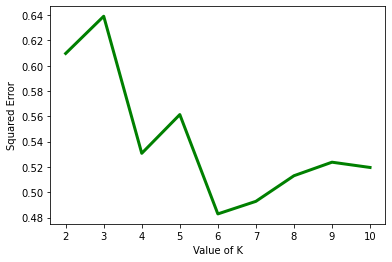

In [ ]:
import matplotlib.pyplot as plt
cost =[]
for i in range(2, 11):
    kmeans = KMeans().setK(i).setSeed(1)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)  
 

plt.plot(range(2, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error")
plt.show() 
 
